In [1]:
#!/usr/bin/env python
# coding: utf-8

import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
import dnds_calculations as dnds

plt.style.use('mplstyle')

In [2]:
rms_fits_file = "final_mosaic.pybdsf_rms.fits"
with fits.open('final_mosaic.pybdsf.srl.fits') as hdul:
    data = hdul[1].data
flux_densities = np.array(data['Total_flux'])
bins=11
flux_bins, bin_centers, counts, bin_edges, bin_widths = dnds.compute_histogram(flux_densities, bins)


In [3]:
counts.sum()

598

In [4]:
len(flux_densities), flux_densities.min(), flux_densities.max()

(640, 0.010124571214612951, 19.079440873276905)

In [5]:
total_valid_area, effective_image_area = dnds.visibility_function(flux_bins, 5, rms_fits_file)
fdr_correction = np.load('fdr_correction.npy')
data = np.load('completeness_corrections_aegean.npz')
bin_centers = data['bin_centers']
completeness_correc_fac_med = data['med']
completeness_correc_fac_low = data['low']
completeness_correc_fac_upp = data['upp']




# data = np.load('completeness_corrections_aegean.npz')
# bin_centers = data['bin_centers']
# completeness_correc_fac_med = data['med']
# completeness_correc_fac_med = fdr_correction
correction_factor = completeness_correc_fac_med * fdr_correction

In [6]:
completeness_correc_fac_med

array([2.04761905, 1.30517241, 1.10859951, 1.02325581, 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ])

In [7]:
correction_factor

array([2.03110599, 1.28753495, 1.09987038, 1.02325581, 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ])

In [8]:
factor = correction_factor / (bin_widths * effective_image_area )
dN_dS = counts * factor
dN_dS_error = np.sqrt(counts) * factor
euclidean_normalized = dN_dS * (bin_centers ** 2.5)
euclidean_normalized_errors = dN_dS_error * (bin_centers ** 2.5)

In [9]:
fdr_correction

array([0.99193548, 0.98648649, 0.99212598, 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ])

In [10]:
si = -0.7
nu_reference = 147.4
nu_gleam = 154 
nu_lofar = 150 

fac_gleam = (nu_reference/nu_gleam)**si
fac_lofar = (nu_reference/nu_lofar)**si

freq_scaling = fac_gleam**2.5
freq_scaling_lofar = fac_lofar**2.5
freq_scaling, freq_scaling_lofar

(1.0796690831049203, 1.0310722705417568)

In [11]:
# Franzen et al. (2019) polynomial coefficients
poly_coeffs = [3.52, 0.307, -0.388, -0.0404, 0.0351, 0.00600]

def franzen_polynomial(flux_Jy):
    log_flux = np.log10(flux_Jy)
    log_euclidean_counts = np.polyval(poly_coeffs[::-1], log_flux)
    return 10**log_euclidean_counts

# Generate flux values to evaluate models
flux_range = np.logspace(np.log10(0.001), np.log10(75), 100)
euclidean_counts_poly = franzen_polynomial(flux_range)


# Existing GLEAM data
gleam_bin_centers = np.array([0.0772, 0.0959, 0.1198, 0.1502, 0.1879, 0.2346, 0.2930, 0.3664, 0.4577, 0.5713, 0.7136,0.8906, 1.1148, 1.3935, 1.7365, 
    2.1738, 2.7123, 3.3869, 4.2445, 5.3171, 6.6146, 8.2454, 10.3656, 12.8897, 16.4515, 19.7413, 25.2264, 40.6881, 75.3991])

gleam_euclidean_normalized = np.array([601, 760, 909, 1071, 1285, 1529, 1800, 2099, 2420, 2674, 2933, 3194, 3465, 3578, 3783,
    3690, 3869, 3932, 3311, 3263, 3097, 3053, 2656, 2733, 2257, 2492, 2223, 1180, 803])

gleam_euclidean_errors = np.array([12, 16, 20, 20, 26, 32, 16, 20, 27, 31, 37, 44, 53, 62, 76, 88, 106, 124,
    138, 158, 178, 209, 230, 268, 302, 356, 406, 241, 434])

gleam_bin_edges = np.array([[0.069, 0.086], [0.086, 0.107], [0.107, 0.134], [0.134, 0.168], [0.168, 0.210], [0.210, 0.262], 
    [0.262, 0.328], [0.328, 0.410], [0.410, 0.512], [0.512, 0.640], [0.640, 0.800], [0.800, 1.000], 
    [1.000, 1.250], [1.250, 1.560], [1.560, 1.950], [1.950, 2.440], [2.440, 3.050], [3.050, 3.820], 
    [3.820, 4.770], [4.770, 5.960], [5.960, 7.450], [7.450, 9.310], [9.310, 11.600], [11.600, 14.600], 
    [14.600, 18.200], [18.200, 22.700], [22.700, 28.400], [28.400, 56.800], [56.800, 113.700]])



# uGMRT 150 MHz (your data)
x_ugmrt = bin_centers
N_ugmrt = euclidean_normalized
err_ugmrt = euclidean_normalized_errors

# GLEAM 154 MHz (Franzen+2019)
x_gleam = gleam_bin_centers
N_gleam = freq_scaling * gleam_euclidean_normalized
err_gleam = freq_scaling * gleam_euclidean_errors



x_Boo = np.array([0.42, 0.59, 0.84, 1.19, 1.68, 2.37, 3.35, 4.74, 6.70, 9.48, 15.9, 31.9, 63.8, 128, 361, 1443])/1e3
N_Boo = np.array([46.96, 53.73, 51.33, 44.17, 44.64, 44.35, 50.83, 56.20, 88.87, 119.8, 137.4, 298.1, 657.5, 1018, 1502, 4861])
err_Boo_minus = np.array([0.74, 0.97, 1.21, 1.43, 1.85, 2.39, 3.32, 4.51, 7.36, 11.1, 12.3, 30.4, 75.9, 159, 289, 1466])
err_Boo_plus  = np.array([0.76, 0.99, 1.23, 1.48, 1.93, 2.52, 3.54, 4.88, 7.96, 12.1, 13.4, 33.5, 84.7, 184, 345, 1908])
N_Boo *= freq_scaling_lofar
err_Boo_minus *= freq_scaling_lofar
err_Boo_plus *= freq_scaling_lofar


# LOckman Hole
x_lotss =  np.array([0.30, 0.42, 0.59, 0.84, 1.19, 1.68, 2.38, 3.36, 4.76, 6.73, 9.51, 16.0, 32.0, 64.0, 128, 362, 1448])/1e3
N_lotss =  np.array([42.35, 48.08, 51.21, 49.18, 43.55, 44.29, 42.01, 49.19, 55.86, 75.45, 113.1, 158.4, 333.2, 543.7, 935.1, 2144, 6335])
err_lotss_plus =  np.array([0.52, 0.67, 0.87, 1.10, 1.34, 1.76, 2.24, 3.16, 4.42, 6.71, 10.7, 13.0, 32.1, 70.6, 160.2, 363, 1909])
err_lotss_minus =  np.array([0.52, 0.66, 0.86, 1.08, 1.30, 1.70, 2.13, 2.98, 4.12, 6.20, 9.9, 12.1, 29.5, 63.2, 139.4, 316, 1537])
N_lotss *= freq_scaling_lofar
err_lotss_plus *= freq_scaling_lofar
err_lotss_minus *= freq_scaling_lofar

# EN1 final catalog
x_en1 =  np.array([0.22, 0.31, 0.43, 0.61, 0.86, 1.22, 1.73, 2.45, 3.46, 4.89, 6.92, 9.79, 16.5, 32.9, 65.8, 132, 372, 1489])/1e3
N_en1 =  np.array([38.85, 43.54, 44.84, 45.40, 42.58, 41.18, 37.59, 39.83, 47.00, 48.44, 69.90, 90.85, 130.7, 385.9, 634.4, 1230, 1271, 2980])
err_en1_plus =  np.array([0.46, 0.60, 0.78, 1.02, 1.28, 1.65, 2.06, 2.79, 3.97, 5.33, 8.35, 12.56, 15.3, 44.2, 98.1, 235, 383, 1929])
err_en1_minus =  np.array([0.46, 0.60, 0.77, 1.00, 1.25, 1.58, 1.96, 2.62, 3.68, 4.84, 7.54, 11.18, 13.9, 40.0, 86.3, 202, 308, 1333])
N_en1 *= freq_scaling_lofar
err_en1_plus *= freq_scaling_lofar
err_en1_minus *= freq_scaling_lofar



In [12]:
# import numpy as np
# import matplotlib.pyplot as plt

# # Figure setup
# plt.figure(figsize=(9,6))

# # Plot Franzen+2019 polynomial fit first (without adding it to the legend yet)
# fit_line, = plt.plot(flux_range, euclidean_counts_poly, 'k--', linewidth=2)

# # Highlight uGMRT points with a larger red marker and black edge
# plt.errorbar(x_ugmrt, N_ugmrt, yerr=err_ugmrt, fmt='o', color='red', markersize=6, mec='black', mew=1., label=r'uGMRT 150 MHz (this work)')

# # Explicit colors for each dataset
# plt.errorbar(x_gleam, N_gleam, yerr=err_gleam, fmt='s', color='blue', label=r'GLEAM 154 MHz')
# plt.errorbar(x_en1, N_en1, yerr=(err_en1_minus, err_en1_plus), fmt='d', color='green', label=r'LOFAR ELAIS-N1 150 MHz')
# plt.errorbar(x_Boo, N_Boo, yerr=(err_Boo_minus, err_Boo_plus), fmt='^', color='purple', label=r'Boötes 150 MHz')
# plt.errorbar(x_lotss, N_lotss, yerr=(err_lotss_minus, err_lotss_plus), fmt='v', color='orange', label=r'LoTSS 150 MHz')

# # Set log-log scales
# plt.xscale('log')
# plt.yscale('log')
# plt.xlabel(r'Flux Density $S$ (Jy)')
# plt.ylabel(r'$S^{2.5} \frac{dN}{dS} \,\, \mathrm{Jy}^{1.5} \, \mathrm{sr}^{-1}$')

# # Get handles and labels, then manually reorder them to put the fit last
# handles, labels = plt.gca().get_legend_handles_labels()
# handles.append(fit_line)
# labels.append(r'Franzen+2019 Fit')

# plt.legend(handles, labels, fontsize='x-small')

# # Save figure
# plt.savefig('source_counts_comparison.pdf', bbox_inches='tight')
# plt.show()


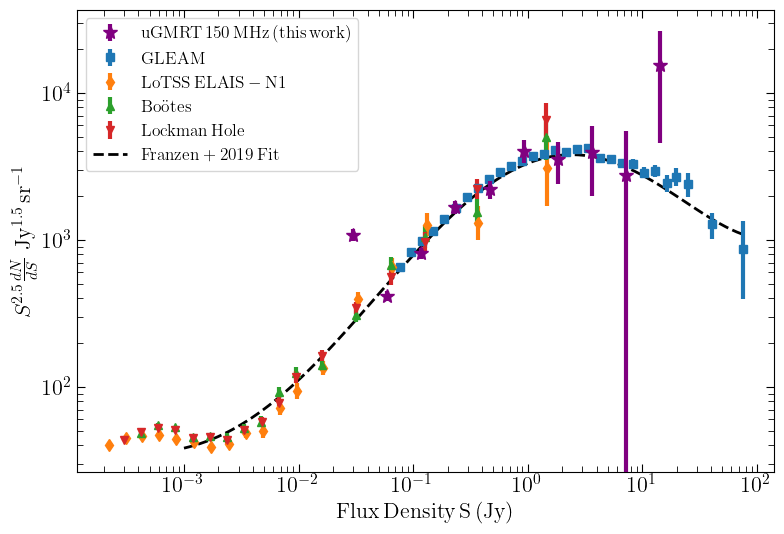

In [23]:
import numpy as np
import matplotlib.pyplot as plt

# Figure setup
plt.figure(figsize=(9,6))

# Plot Franzen+2019 polynomial fit first (without adding it to the legend yet)
fit_line, = plt.plot(flux_range, euclidean_counts_poly, 'k--', linewidth=2)

# Highlight uGMRT points with a larger red star marker, black edge, and subtle glow
plt.errorbar(x_ugmrt, N_ugmrt, yerr=err_ugmrt, fmt='*', color='purple', markersize=10,  zorder=11,
             label=r'$\rm{uGMRT\, 150\, MHz\, (this\, work)}$')
# plt.scatter(x_ugmrt, N_ugmrt, s=150, color='red', alpha=0.3)

# Explicit colors for each dataset
plt.errorbar(x_gleam, N_gleam, yerr=err_gleam, fmt='s', color='C0', label=r'$\rm{GLEAM}$')
plt.errorbar(x_en1, N_en1, yerr=(err_en1_minus, err_en1_plus), fmt='d', color='C1', label=r'$\rm{LoTSS\, ELAIS-N1}$')
plt.errorbar(x_Boo, N_Boo, yerr=(err_Boo_minus, err_Boo_plus), fmt='^', color='C2', label=r'$\rm{Bo\ddot{o}tes}$')
plt.errorbar(x_lotss, N_lotss, yerr=(err_lotss_minus, err_lotss_plus), fmt='v', color='C3', label=r'$\rm{Lockman\, Hole}$')

# Set log-log scales
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$\rm{Flux\, Density\, S\, (Jy)}$')
plt.ylabel(r'$S^{2.5} \frac{dN}{dS} \,\, \rm{Jy^{1.5} \, sr^{-1}}$')

# Get handles and labels, then manually reorder them to put the fit last
handles, labels = plt.gca().get_legend_handles_labels()
handles.append(fit_line)
labels.append(r'$\rm{Franzen+2019\, Fit}$')

plt.legend(handles, labels, fontsize='x-small')

# Save figure
plt.savefig('source_counts_comparison.pdf', bbox_inches='tight')
plt.show()


In [24]:
# data = np.load('completeness_corrections_aegean.npz')
# bin_centers = data['bin_centers']
# completeness_correc_fac_median = data['med']
# completeness_correc_fac_lower_bound = data['low']
# completeness_correc_fac_upper_bound = data['upp']



In [25]:
bin_centers.shape

(10,)

In [26]:
import numpy as np

def generate_latex_table(bin_edges, S, dS, N, C_fdr, C_c, C_c_err_upper, C_c_err_lower, V, dNdS, dNdS_err):
    S_i = bin_edges[:-1]  # Lower edges
    S_f = bin_edges[1:]   # Upper edges
    
    table = []
    table.append("\\begin{tabular}{ccccccccc}")
    table.append("    \\hline")
    table.append("    $S_i$ & $S_f$ & $S$ & $\\Delta S$ & N & $C_{\\rm fdr}$ & $C_{\\rm c}$ & $V(S)$  & $S^{2.5}\\,dN/dS$ \\\\")
    table.append("    (Jy) & (Jy) &  (Jy) &  (Jy) &  &  &  &  (\\%) &  (Jy$^{3/2}$ sr$^{-1}$) \\\\")
    table.append("    \\hline")
    
    for i in range(len(S_i)):
        if not np.isnan(C_c_err_upper[i]) and not np.isnan(C_c_err_lower[i]):
            C_c_str = f"${C_c[i]:.3f}^{{+{C_c_err_upper[i]:.3f}}}_{{-{C_c_err_lower[i]:.3f}}}$"
        else:
            C_c_str = f"${C_c[i]:.3f}$"
        
        C_fdr_str = f"${C_fdr[i]:.3f}$" if C_fdr[i] != -1 else "-"
        dNdS_str = f"$ {dNdS[i]:.2f} \\pm {dNdS_err[i]:.2f} $"
        
        row = (
            f"    {S_i[i]:.3f} & {S_f[i]:.3f} & {S[i]:.3f} & {dS[i]:.4f} & "
            f"{N[i] if N[i] != -1 else '-'} & "
            f"{C_fdr_str} & "
            f"{C_c_str} & "
            f"{V[i]:.2f} & "
            f"{dNdS_str} \\\\"
        )
        table.append(row)
    
    table.append("    \\hline")
    table.append("\\end{tabular}")
    
    return "\n".join(table)

# Example arrays (replace with actual data)
S = bin_centers
dS = bin_widths
N = counts
C_fdr = fdr_correction
C_c = completeness_correc_fac_med
C_c_err_upper = completeness_correc_fac_upp
C_c_err_lower = completeness_correc_fac_low
V = 100 * effective_image_area / total_valid_area
dNdS = N_ugmrt 
dNdS_err = err_ugmrt

latex_table = generate_latex_table(bin_edges, S, dS, N, C_fdr, C_c, C_c_err_upper, C_c_err_lower, V, dNdS, dNdS_err)
print(latex_table)


\begin{tabular}{ccccccccc}
    \hline
    $S_i$ & $S_f$ & $S$ & $\Delta S$ & N & $C_{\rm fdr}$ & $C_{\rm c}$ & $V(S)$  & $S^{2.5}\,dN/dS$ \\
    (Jy) & (Jy) &  (Jy) &  (Jy) &  &  &  &  (\%) &  (Jy$^{3/2}$ sr$^{-1}$) \\
    \hline
    0.020 & 0.040 & 0.030 & 0.0197 & 124 & $0.992$ & $2.048^{+0.152}_{-0.157}$ & 17.08 & $ 1084.42 \pm 97.38 $ \\
    0.040 & 0.079 & 0.059 & 0.0392 & 148 & $0.986$ & $1.305^{+0.095}_{-0.075}$ & 93.91 & $ 417.57 \pm 34.32 $ \\
    0.079 & 0.157 & 0.118 & 0.0778 & 127 & $0.992$ & $1.109^{+0.037}_{-0.056}$ & 99.44 & $ 808.98 \pm 71.79 $ \\
    0.157 & 0.311 & 0.234 & 0.1544 & 101 & $1.000$ & $1.023^{+0.024}_{-0.023}$ & 100.00 & $ 1665.67 \pm 165.74 $ \\
    0.311 & 0.618 & 0.464 & 0.3067 & 49 & $1.000$ & $1.000^{+0.000}_{-0.000}$ & 100.00 & $ 2210.00 \pm 315.71 $ \\
    0.618 & 1.227 & 0.922 & 0.6090 & 32 & $1.000$ & $1.000^{+0.000}_{-0.000}$ & 100.00 & $ 4039.02 \pm 714.01 $ \\
    1.227 & 2.436 & 1.831 & 1.2094 & 10 & $1.000$ & $1.000^{+0.000}_{-0.000}$ & 100.

In [27]:
counts.sum()

598

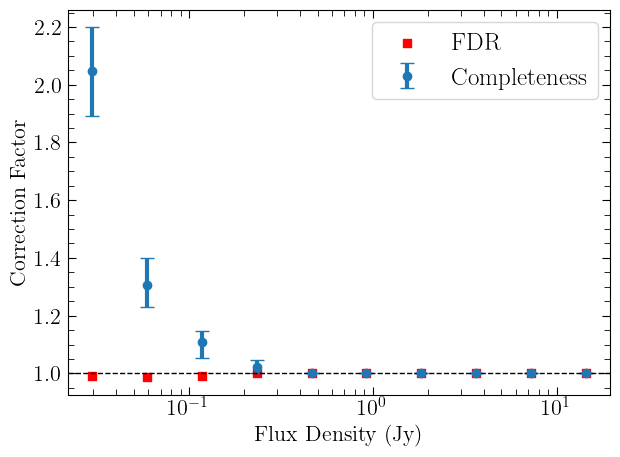

In [28]:
import numpy as np
import matplotlib.pyplot as plt

# Enable LaTeX rendering
plt.rcParams.update({"text.usetex": True, "font.family": "serif"})

# Create figure
plt.figure(figsize=(7, 5))

# Plot error bars for the median correction factor
plt.errorbar(bin_centers, completeness_correc_fac_med, 
             yerr=[completeness_correc_fac_low, completeness_correc_fac_upp], 
             fmt='o', capsize=5, label=r"\textrm{Completeness}")

# Draw horizontal dashed line at y = 1
plt.axhline(y=1, color='black', linestyle='--', linewidth=1)

# Plot FDR correction points as red squares
plt.scatter(bin_centers, fdr_correction, color='red', marker='s', label=r"\textrm{FDR}")

# Set log scale for x-axis
plt.xscale("log")
# plt.yscale("log")

# plt.yticks([0.75, 1, 1.25, 1.5, 1.75, 2, 2.25], 
#            [r"$0.75$", r"$1$", r"$1.25$", r"$1.5$", r"$1.75$", r"$2$", r"$2.25$"])

# plt.yticks([0.75, 1, 1.5, 2, 2.5], 
#            [r"$0.75$", r"$1$", r"$1.5$", r"$2$", r"$2.5$"])

# Labels and title
plt.xlabel(r"\textrm{Flux Density (Jy)}")
plt.ylabel(r"\textrm{Correction Factor}")

# Show legend
plt.legend()

# Show plot
plt.savefig('corrections.pdf', bbox_inches='tight')

In [29]:
fdr_correction, completeness_correc_fac_med


(array([0.99193548, 0.98648649, 0.99212598, 1.        , 1.        ,
        1.        , 1.        , 1.        , 1.        , 1.        ]),
 array([2.04761905, 1.30517241, 1.10859951, 1.02325581, 1.        ,
        1.        , 1.        , 1.        , 1.        , 1.        ]))

In [20]:
%

UsageError: Line magic function `%` not found.
